# Credit Risk Analysis

### Arhum Zafar
#### DTSC 691 - Spring 2, 2022

### Introduction

This notebook consists of the analysis and work I did to build a model to predict credit risk. The overall objective of this project is to utilize machine learning methods to model credit risk among customers, and then **build a binary classfier that attempts to predict whether the loan will default.**
<br>

This notebook contains the end-to-end process I took beginning with loading in and cleaning the data, all the way to optimizing a model and packaging it for deployment in a web app via Streamlit.
<br>
<br>

*References are located at the bottom of this notebook.*

###### Dependencies

In [47]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
import lightgbm as lgb

import sklearn
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import accuracy_score, fbeta_score, roc_curve, roc_auc_score
from sklearn.ensemble import StackingClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.svm import SVC 
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.model_selection import cross_val_score 
from statistics import mean, stdev


# In case you don't catch it later on in the notebook -- I use 99 as my random state (i.e. RANDOM_STATE=99)

#### Import data and data cleaning

In [10]:
raw_data = pd.read_csv("credit_risk_dataset.csv")
raw_data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,30
32577,54,120000,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,19
32578,65,76000,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,28
32579,56,150000,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,26


In [11]:
raw_data.shape

(32581, 12)

In [12]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [13]:
# Check for missing data
raw_data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

Looking above, we have missing entries in the `person_emp_length` and `loan_int_rate` features.

<br>

To clarify, the `person_emp_length` is the employment length of the borrower in years.

<br>

`loan_int_rate` is the agreed interest rate applied to the loan.

<br>

To get a better idea of what I will impute into these missing values, I will first look at the mean and median values for these respective features.

In [14]:
raw_data["person_emp_length"].mean(), raw_data["person_emp_length"].median()

(4.789686296787225, 4.0)

In [15]:
raw_data["loan_int_rate"].mean(), raw_data["loan_int_rate"].median()

(11.01169489224439, 10.99)

We can also plot the features to understand their distributions.

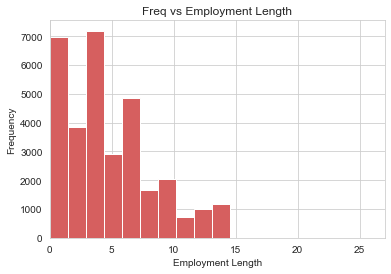

In [400]:
plt.hist(raw_data['person_emp_length'], color='r')
plt.xlim([0,27])
plt.xlabel("Employment Length")
plt.ylabel("Frequency")
plt.title("Freq vs Employment Length")
plt.show()

Text(0.5, 1.0, 'Freq vs Interest Rate')

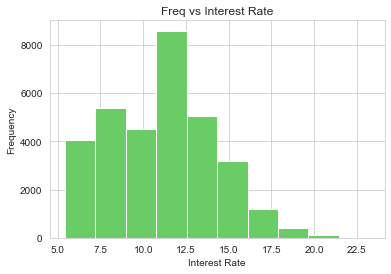

In [401]:
plt.hist(raw_data['loan_int_rate'], color="g")
plt.xlabel("Interest Rate")
plt.ylabel("Frequency")
plt.title("Freq vs Interest Rate")

By looking at the above graphs, as well as the mean and median values, it can be seen both of the features are not normally distributed. Additionally, since the mean and median values are so similar to one another, I will impute the median into the missing values.

In [16]:
raw_data["person_emp_length"].fillna(raw_data["person_emp_length"].median(), inplace=True)
raw_data["loan_int_rate"].fillna(raw_data["loan_int_rate"].median(), inplace=True)

In [17]:
raw_data.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [18]:
# Check for duplicates, if present, drop them.
raw_data.duplicated().sum()

165

In [19]:
raw_data.drop_duplicates(inplace=True)
raw_data.shape

(32416, 12)

Looks like we dropped 165 rows of duplicate data from the dataframe.

###### Removing Outliers and Cleaning things up 

In [20]:
# Some of these feature names are too long, I will shorten them up
raw_data = raw_data.rename(columns={"cb_person_default_on_file":"default_history",
                                    "cb_person_cred_hist_length": "cr_history_length"})

In [21]:
# I also want to make sure that my dataset is representative of a general population.
# I will remove anyone in the dataset that is older than 100 years.

raw_data = raw_data[raw_data["person_age"] <= 100]

In [22]:
raw_data["person_age"].min(), raw_data["person_age"].mean()

(20, 27.730369319058344)

With the youngest person in the dataset being 20 years old, we don't need to worry about outliers of younger borrowers, for example children, being in our dataset.

In [23]:
# Find more outliers

def remove_outliers(dataframe, column):
    "function that iterates through specified columns, identifies outliers, and removes them"
    quantile_1 = dataframe[column].quantile(0.25)
    quantile_3 = dataframe[column].quantile(0.75)
    
    #IQR
    inter_quart_range = quantile_3 - quantile_1
    lower_range = quantile_1 - 1.5*inter_quart_range
    upper_range = quantile_3 + 1.5*inter_quart_range
    
    # update dataframe with 
    dataframe[column] = np.where(dataframe[column] > upper_range, upper_range, dataframe[column])
    dataframe[column] = np.where(dataframe[column] < lower_range, lower_range, dataframe[column])
    
    return dataframe

To make this dataset even more representative of a general population, I need to ensure that I acknowledge, and account for any outliers. 

In [24]:
# features that I think are important but may have outliers
outlier_features = ["person_emp_length", "cr_history_length", "person_income"]

for column in outlier_features:
    remove_outliers(raw_data, column)

In [25]:
raw_data

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,default_history,cr_history_length
0,22,59000.0,RENT,14.5,PERSONAL,D,35000,16.02,1,0.59,Y,3.0
1,21,9600.0,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2.0
2,25,9600.0,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3.0
3,23,65500.0,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2.0
4,24,54400.0,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000.0,MORTGAGE,1.0,PERSONAL,C,5800,13.16,0,0.11,N,15.5
32577,54,120000.0,MORTGAGE,4.0,PERSONAL,A,17625,7.49,0,0.15,N,15.5
32578,65,76000.0,RENT,3.0,HOMEIMPROVEMENT,B,35000,10.99,1,0.46,N,15.5
32579,56,140250.0,MORTGAGE,5.0,PERSONAL,B,15000,11.48,0,0.10,N,15.5


###### Visualizations and EDA

array([[<AxesSubplot:title={'center':'person_age'}>,
        <AxesSubplot:title={'center':'person_income'}>,
        <AxesSubplot:title={'center':'person_emp_length'}>],
       [<AxesSubplot:title={'center':'loan_amnt'}>,
        <AxesSubplot:title={'center':'loan_int_rate'}>,
        <AxesSubplot:title={'center':'loan_status'}>],
       [<AxesSubplot:title={'center':'loan_percent_income'}>,
        <AxesSubplot:title={'center':'cr_history_length'}>,
        <AxesSubplot:>]], dtype=object)

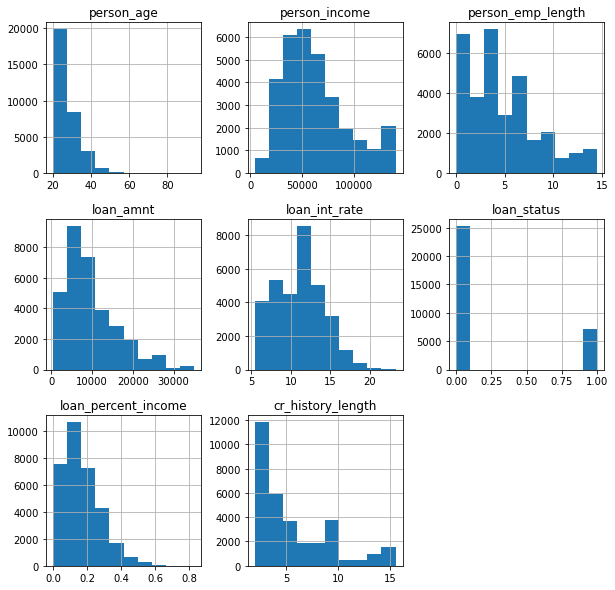

In [21]:
raw_data.hist(figsize=(10,10))

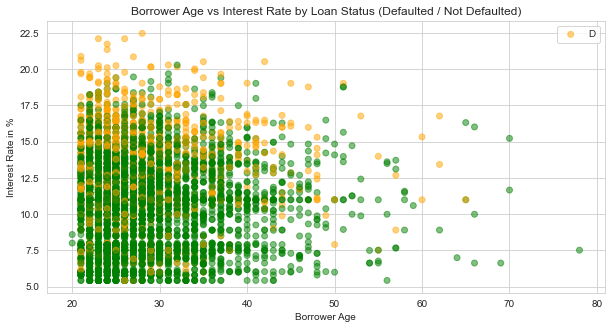

In [402]:
# Visualize the age of the borrower, the interest rate on their loan, and whether the loan was defaulted.

plt.figure(figsize=(10,5))
plt.scatter(raw_data["person_age"][::5], raw_data["loan_int_rate"][::5],
            c=raw_data["loan_status"][::5], cmap = mpl.colors.ListedColormap(["green", "orange"]),
           alpha=0.5)
plt.title("Borrower Age vs Interest Rate by Loan Status (Defaulted / Not Defaulted)")
plt.xlabel("Borrower Age")
plt.ylabel("Interest Rate in %")
plt.legend(labels = "Defaulted")

In [23]:
raw_data["loan_int_rate"].mean(),raw_data["loan_int_rate"].median()

(11.014528400850406, 10.99)

The scatter plot above definitely is not the most conclusive visualization, but it does appear that loans with higher interest rates are more likely to be defaulted on, across all ages. 

<br>
Also, it seems like there is slight downtrend on age vs. interest rate. That is, the older the borrower, the lower the interest rate is. Some of the higher interest rates are amongst the younger borrowers

I'm also curious to see the relationship between the amount borrowed and interest rate, and whether or not the loan was defaulted on.

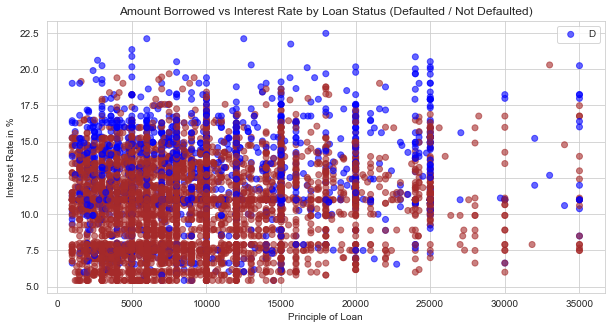

In [403]:

plt.figure(figsize=(10,5))
plt.scatter(raw_data["loan_amnt"][::5], raw_data["loan_int_rate"][::5],
            c=raw_data["loan_status"][::5], cmap = mpl.colors.ListedColormap(["brown", "blue"]),
           alpha=0.6)
plt.title("Amount Borrowed vs Interest Rate by Loan Status (Defaulted / Not Defaulted)")
plt.xlabel("Principle of Loan")
plt.ylabel("Interest Rate in %")
plt.legend(labels = "Defaulted")

Looking above, it's hard to make a clear conclusion but I do see more blue at the top than brown, so it seems as if both big and small loans with higher interest rates are the loans more likely to default.

<br>
Interest rates will be something to keep an eye on as we continue to analyze.

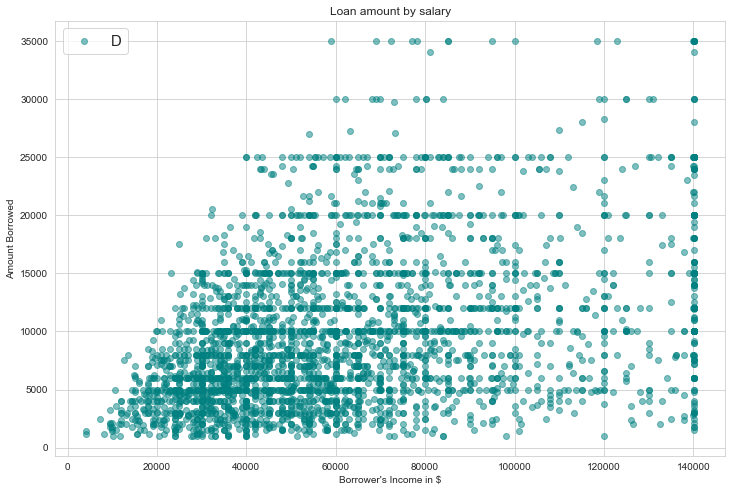

In [404]:
# Plot Borrowers Salary vs Loan Amount -- plotting every 10th person/datapoint.

plt.figure(figsize=(12,8))
plt.scatter(raw_data["person_income"][::10], raw_data["loan_amnt"][::10], alpha=0.5 , c="teal")
plt.title("Loan amount by salary")
plt.xlabel("Borrower's Income in $")
plt.ylabel("Amount Borrowed")
plt.legend(labels = "Defaulted", fontsize=15)

Above, it also looks like the more a borrower earns, the larger a loan they can take out. We do not see anyone making less than 20,000 dollars in income borrow than $10,000.
<br>

However, it is important to note that although higher earners can take out larger loans, it doesn't mean they need to. The amount of the loan is going to be dictated be the loan intent.

Text(0, 0.5, 'Intent of Loan')

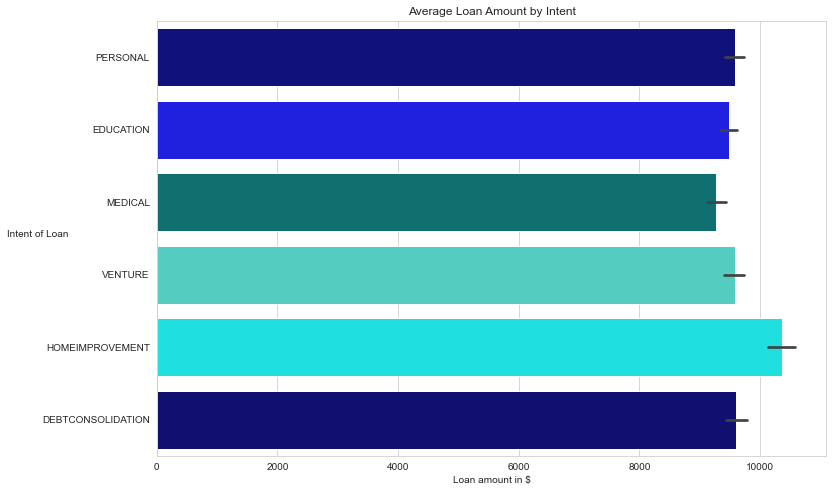

In [395]:
colors = [ "darkblue","blue", "teal", "turquoise", "cyan",  "navy"]

# Loan amount by loan intent
sns.set_style('whitegrid')
sns.set_color_codes('muted')
plt.figure(figsize=(12,8))
sns.barplot(x=raw_data["loan_amnt"], y=raw_data["loan_intent"], palette=colors)
plt.title("Average Loan Amount by Intent")
plt.xlabel("Loan amount in $")
plt.ylabel("Intent of Loan", rotation=0)

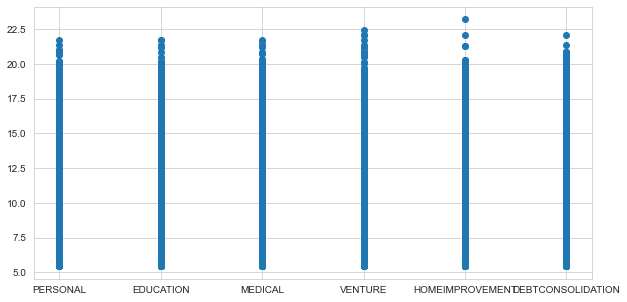

In [405]:
# I'm curious if interest rates vary by intent.
# Plot interest rates by loan intent. Not concerned about default status

plt.figure(figsize = (10,5))
plt.scatter(raw_data["loan_intent"], raw_data["loan_int_rate"])

plt.show()

Looks like interest rates do not differ by intent, they can be low and high. We can also look at the mean interest rate by loan intent.

In [28]:
raw_data["loan_int_rate"].groupby(raw_data["loan_intent"]).mean()

loan_intent
DEBTCONSOLIDATION    10.989632
EDUCATION            10.957928
HOMEIMPROVEMENT      11.189900
MEDICAL              11.057009
PERSONAL             11.002420
VENTURE              10.956702
Name: loan_int_rate, dtype: float64

Now that we've looked at interest rates, I want to see what else can be traced to a default.

Text(0.5, 0, 'Correlation with Loan Status')

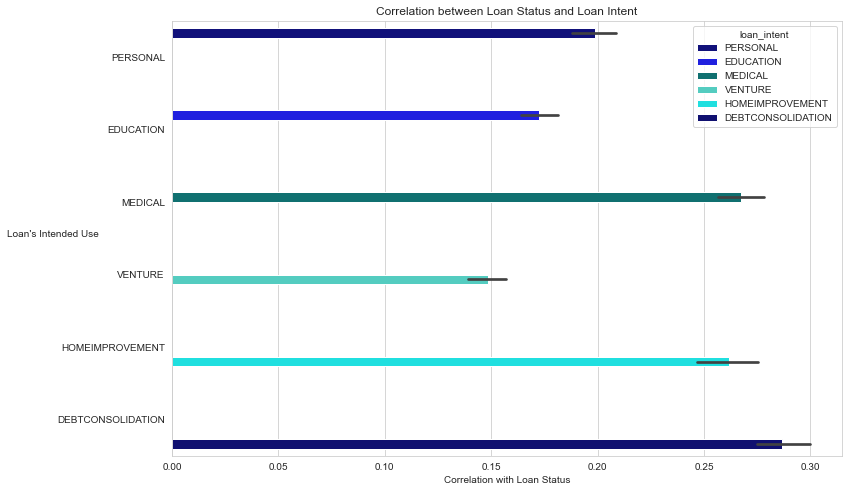

In [399]:
# Loan intent vs loan status
plt.figure(figsize=(12,8))
sns.barplot(x=raw_data["loan_status"], y=raw_data["loan_intent"], 
            hue=raw_data["loan_intent"], palette=colors)
plt.title("Correlation between Loan Status and Loan Intent", size=12)
plt.ylabel("Loan's Intended Use", rotation=0)
plt.xlabel("Correlation with Loan Status")

In [362]:
pd.crosstab(raw_data["loan_status"], raw_data["loan_intent"])

loan_intent,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE
loan_status,,,,,,
0,3701,5303,2654,4425,4403,4836
1,1488,1106,940,1617,1094,844


Above, it looks like those who take out a loan intended for Debt Consolidation are more likely to default on the loan compared to other uses. This may make sense as those who are borrowing more money to get out of debt were already in trouble to begin with.

<br>
We also see that Medical and Home Improvement uses have higher correlations.

In our dataset, `loan_grade`, simply represents the loan grade assigned to each loan. *Loan Grading* is the process of assigning a quality score (grade) to a loan application to identify any risk of default. This score is calculated based off the credit history, likelihood of repayment, and the quality of the collateral of the given borrower [1].

<br>
In the contingency table below, its clear to see that loans assigned higher loan grades are less likely to default. I'd go ahead and make the assumption loans with a loan grade of 'A' and low interest rates were also highly unlikely to default.

In [32]:
pd.crosstab(raw_data["default_history"], raw_data["loan_grade"])

loan_grade,A,B,C,D,E,F,G
default_history,,,,,,,
N,10703,10384,3191,1747,499,129,28
Y,0,0,3245,1873,464,112,36


In [31]:
# Loan Status and Home Ownership
pd.crosstab(raw_data["person_home_ownership"], raw_data["loan_status"])

loan_status,0,1
person_home_ownership,,
MORTGAGE,11680,1687
OTHER,73,33
OWN,2371,192
RENT,11198,5177


Similar to the *Interest Rate by Loan Grade* bar chart above, borrowers with no history of defaulting usually received loan grades of A or B.

<br>

**Below**, we see that even loans that are assigned loan grades of A or B do defaulted on. So although a borrowers past history is important, it surely cannot be relied on entirely to make an accurate prediction.

In [33]:
pd.crosstab(raw_data["loan_status"], raw_data["loan_grade"])

loan_grade,A,B,C,D,E,F,G
loan_status,,,,,,,
0,9637,8689,5100,1482,342,71,1
1,1066,1695,1336,2138,621,170,63


In [34]:
history = pd.crosstab(raw_data["default_history"], raw_data["loan_status"])
history

loan_status,0,1
default_history,,
N,21762,4919
Y,3560,2170


In [35]:
# Calculate how many people defaulted for the first time, as well as second time.
total = history.iloc[0].sum()
who_defaulted = history.iloc[0,1]

round(who_defaulted/total * 100,2)


18.44

Considering the banks being very methodical of who gets a loan and who doesn't. About 18.44% of people who recieved a loan defaulted for the first time.

In [36]:
total2 = history.iloc[1].sum()
who_defaulted2 = history.iloc[1,1]

round(who_defaulted2/total2 *100, 2)

37.87

And 37.87% of those who defaulted on a loan before and recieved a new one, ended up defaulting again.

<br>

This just shows that regardless of all the vetting and preventative measures a bank uses, even the best borrowers can default on a loan. That being said, I guess the primary objective is to create a system that minimizes defaults.

In [37]:
# Want to see the counts of the labels --
# 0 = No Default
# 1 = Default

raw_data["loan_status"].value_counts()

0    25322
1     7089
Name: loan_status, dtype: int64

Looking above, there are significantly more data points belonging to the No Default class than Defaults. That being said, we do have class imbalance in our dataset. We will keep this in mind when considering the best performance metric, as well as if we need to considering resampling or generating synthetic samples. 

In [38]:
# Do interest rates increase for those who have a default history?
pd.crosstab(raw_data['default_history'], raw_data['person_home_ownership'], 
            values = raw_data['loan_int_rate'], aggfunc = 'median')

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
default_history,,,,
N,10.25,11.14,10.59,10.99
Y,13.98,14.26,14.26,13.99


In [39]:
# Do interest rates increase for those who have a default history? -- this time group by loan intent
pd.crosstab(raw_data['default_history'], raw_data['loan_intent'], 
            values = raw_data['loan_int_rate'], aggfunc = 'median')

loan_intent,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE
default_history,,,,,,
N,10.62,10.62,10.74,10.74,10.65,10.65
Y,14.09,13.85,14.10,14.11,14.11,13.99


Looking at the two contingency tables above, interest rates defintely do increase for those who have defaulted on a loan in the past, regardless of intended use of the loan.

###### Correlation Matrix

Text(0.5, 1.0, 'Feature Correlation Heatmap')

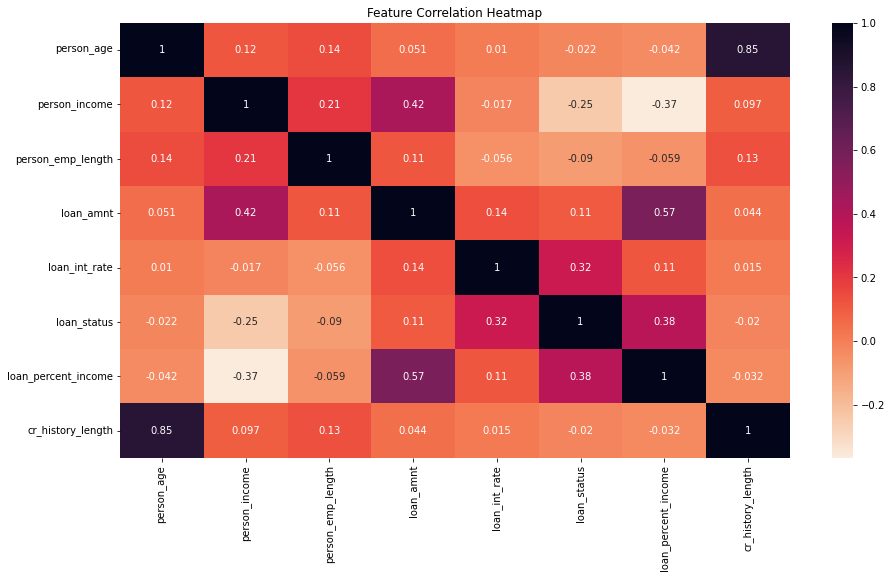

In [40]:
plt.figure(figsize=(15,8))
sns.heatmap(raw_data.corr(), annot=True, cmap="rocket_r")
plt.title("Feature Correlation Heatmap")

We can see some moderate to weak positive/negative correlation between features. Firstly, there is moderate correlation between `loan_amount` and `person_income`, which makes sense -- the more someone earns, the more money they would be approved to borrow. There is also strong positive correlation between `cr_history_length` and `person_age` -- the younger someone is, the smaller history would be. The feature with the largest (in absolute value) correlation to `loan_status`, the labels of the dataset, was `loan_percent_income`, with an unimpressive score of **0.38**. This value isn't large enough to make any conclusions, but I could see that those whose loans are a sizeable amount compared to their income are likely to default to on their loans. 

<br>

Once I build a model, I'll be curious as to what features contribute the most to the model's success.

###### One Hot Encoding

By using the `.info()` function on the original dataframe near the top of the notebook, we saw that there are some categorical features in our dataset like `person_home_ownership`, `loan_intent`, `loan_grade`, and more. I need to encode these features in order to use them in the models we will build.

In [26]:
# Seperate Categorical and Numeric Columns

numerical_features = raw_data.select_dtypes(exclude='object')
categorical_features = raw_data.select_dtypes(include='object')

# Encode categorical data using Pandas -- I could also use sklearn's OneHotEncoder()
one_hot_categorical_features = pd.get_dummies(categorical_features)
one_hot_categorical_features

,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_intent_DEBTCONSOLIDATION,loan_intent_EDUCATION,loan_intent_HOMEIMPROVEMENT,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,default_history_N,default_history_Y
0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1
1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0
32577,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0
32578,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0
32579,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0


In [27]:
# Concatenate Numerical and One-Hot-Encoded dataframes
# This dataframe holds all numerical features, encoded features, and the class labels
dataset = pd.concat([numerical_features, one_hot_categorical_features],axis=1)

In [28]:
# Dataset will now have 27 columns
dataset

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cr_history_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,default_history_N,default_history_Y
0,22,59000.0,14.5,35000,16.02,1,0.59,3.0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,21,9600.0,5.0,1000,11.14,0,0.10,2.0,0,0,...,0,0,1,0,0,0,0,0,1,0
2,25,9600.0,1.0,5500,12.87,1,0.57,3.0,1,0,...,0,0,0,1,0,0,0,0,1,0
3,23,65500.0,4.0,35000,15.23,1,0.53,2.0,0,0,...,0,0,0,1,0,0,0,0,1,0
4,24,54400.0,8.0,35000,14.27,1,0.55,4.0,0,0,...,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,57,53000.0,1.0,5800,13.16,0,0.11,15.5,1,0,...,0,0,0,1,0,0,0,0,1,0
32577,54,120000.0,4.0,17625,7.49,0,0.15,15.5,1,0,...,0,1,0,0,0,0,0,0,1,0
32578,65,76000.0,3.0,35000,10.99,1,0.46,15.5,0,0,...,0,0,1,0,0,0,0,0,1,0
32579,56,140250.0,5.0,15000,11.48,0,0.10,15.5,1,0,...,0,0,1,0,0,0,0,0,1,0


In [29]:
dataset.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cr_history_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'default_history_N',
       'default_history_Y'],
      dtype='object')

Now that I've encoded my features, I will go ahead and perform feature scaling to make sure the features are ready to be used as inputs.

In [30]:
# Min Max Scaling

# Get the features into a dataframe, no need to scale the labels.
features = dataset.drop("loan_status", axis=1)

# Import and Instantiate Scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# `scaled_features` now holds the scaled features
scaled_features = pd.DataFrame(scaler.fit_transform(features), index=features.index, columns=features.columns)
scaled_features

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cr_history_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,default_history_N,default_history_Y
0,0.027027,0.403670,1.000000,1.000000,0.595506,0.710843,0.074074,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,0.013514,0.041101,0.344828,0.014493,0.321348,0.120482,0.000000,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.067568,0.041101,0.068966,0.144928,0.418539,0.686747,0.074074,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.040541,0.451376,0.275862,1.000000,0.551124,0.638554,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.054054,0.369908,0.551724,1.000000,0.497191,0.662651,0.148148,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32576,0.500000,0.359633,0.068966,0.153623,0.434831,0.132530,1.000000,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
32577,0.459459,0.851376,0.275862,0.496377,0.116292,0.180723,1.000000,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32578,0.608108,0.528440,0.206897,1.000000,0.312921,0.554217,1.000000,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
32579,0.486486,1.000000,0.344828,0.420290,0.340449,0.120482,1.000000,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Model Building

In this section, I will be building models that effectively predict whether a given borrower will or will not default on their loan. I have my features standardized and labels ready to go.
<br>

I will first start with building a baseline model. Here, I am not concerned about finetuning the model or optimizing hyperparameters, I simply want to build a baseline model that can accomplish the job of predicting *Default (1)* or *Not Default (0)*. Since this is a binary classification task, I will start with a logistic regression and work from there.

In [31]:
# Split and create train/tests set
X = scaled_features
y = dataset[["loan_status"]]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=.2, random_state=99)

In [32]:
X_train
# X_test,
# y_train,
# y_test

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cr_history_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,default_history_N,default_history_Y
6335,0.027027,0.330275,0.413793,0.055072,0.020787,0.060241,0.148148,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27753,0.094595,1.000000,0.137931,0.134058,0.529213,0.036145,0.296296,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
12535,0.081081,0.574716,0.689655,0.524638,0.088202,0.277108,0.000000,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27070,0.108108,0.851376,0.827586,0.565217,0.226404,0.204819,0.592593,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27932,0.135135,0.386261,0.137931,0.333333,0.197753,0.253012,0.518519,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9933,0.067568,0.447706,0.206897,0.020290,0.312921,0.024096,0.000000,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3244,0.040541,0.440367,0.482759,0.086957,0.522472,0.060241,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
13501,0.027027,0.337615,0.275862,0.347826,0.105056,0.301205,0.000000,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
23713,0.135135,0.176147,0.000000,0.253623,0.340449,0.397590,0.518519,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


#### Baseline Model - Logistic Regression

In [222]:
# Import and Instantiate Logistic Regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(random_state=99)

# fit model
log_reg.fit(X_train, y_train)

# produce predictions
y_pred_log_reg = log_reg.predict(X_test)

###### Logistic Regression Performance Metrics

In [223]:
# Evaluation Metrics
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix

cm_log_reg = confusion_matrix(y_test, y_pred_log_reg)
log_reg_f1 = f1_score(y_test, y_pred_log_reg)
log_reg_recall = recall_score(y_test, y_pred_log_reg)
log_reg_prec = precision_score(y_test, y_pred_log_reg)

print("Logistic Regression recall score: {}".format(log_reg_recall))
print("Logistic Regression precision score: {}".format(log_reg_prec))
print("Logistic Regression F1 score: {}".format(log_reg_f1))

Logistic Regression recall score: 0.5641025641025641
Logistic Regression precision score: 0.751953125
Logistic Regression F1 score: 0.6446211804102134


We can briefly look at the above metrics.

<br>

We got an **Recall Score** of 0.564, which was not too impressive. This is partly because we only correctly classified 770 positive labels, and misclassified 595. 

<br>

We got a **Precision Score** for 0.7519. This score is a bit better, but it doesn't account for misclassified positive labels. On the other hand, it does account for the 254 false positives.

<br>

The **F1 Score** was 0.6446. This is just the harmonic mean of the above two metrics. There's definitely room for improvement here, but again, this model was simply a baseline.

<br>

We can also look at the confusion matrix below.

In [43]:
# Define function to plot confusion matrices
def print_cm(dataset, title):
    plt.figure(figsize=(12,8))
    sns.heatmap(dataset, annot=True, fmt='g', cmap="Blues")# yticklabels=ylab)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

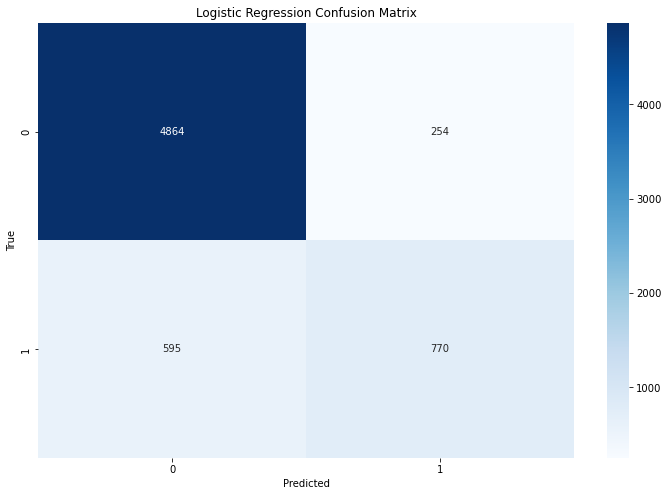

In [225]:
print_cm(cm_log_reg, "Logistic Regression Confusion Matrix")

As this is binary classificaton task, and our dataset has class imbalance, accuracy isn't the best metric, but we can calculate it here for reference.

In [226]:
from sklearn.metrics import accuracy_score
print("Logistic Regression Accuracy score: {}".format(accuracy_score(y_test, y_pred_log_reg))) 

Logistic Regression Accuracy score: 0.8690421101341971


Since my main objective of this model is to accurately and consistently predict whether a borrower will default, I really need to **prioritize minimizing false negatives** -- where the model predicts that the borrower will not default, when they actually will -- the banks cannot afford to accidently give a loan to someone who is very likely to default.

<br>

Because of this, I will consider the **F2 Score** as one of the primary performance metrics for this project, as it places a strong emphasis on recall, alongside the **Confusion Matrix**, the **ROC Curve/AUC**, and **F1 Score**. 
<br>

The F2 Score is calculated as:

<br>

![image](f2.jpeg)

<br>

We calculate the F2 score below.

In [56]:
from sklearn.metrics import fbeta_score
print("Logistic Regression F2 Score: {}".format(fbeta_score(y_test, y_pred_log_reg, beta=2))) 

Logistic Regression F2 Score: 0.5937692782233189


We can also create a Receiver Operating Characteristic (**ROC**) curve and calculate the Area Under the ROC Curve (**AUC**).

In [46]:
# Function that plots ROC curves
def plot_roc_curve(fpr, tpr, title):
    plt.plot(fpr, tpr, linewidth=2, label="ROC")
    plt.plot([0, 1], [0, 1], 'k--', label="Random Chance") # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)
    plt.title(title, fontsize=18)
    plt.legend()
    plt.grid(True)      

AUC: 0.7572369014338534


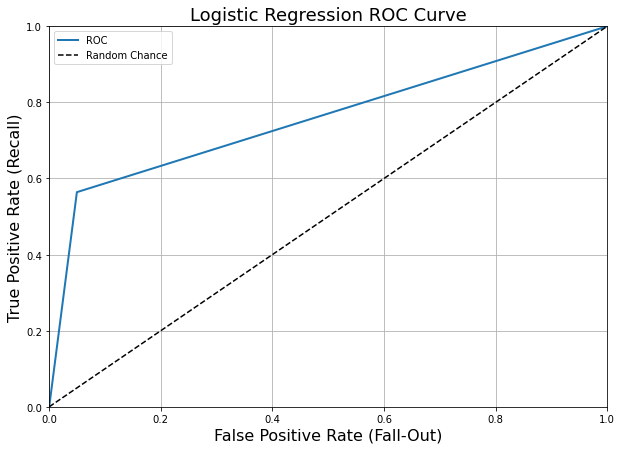

In [209]:
# Calculate FPR and TPR for logistic regression
log_fpr, log_tpr, _ =roc_curve(y_test, y_pred_log_reg) 

# Plot ROC curve
plt.figure(figsize=(10, 7))                         
plot_roc_curve(log_fpr, log_tpr, "Logistic Regression ROC Curve")
log_reg_auc = roc_auc_score(y_test, y_pred_log_reg)
print("AUC: {}".format(log_reg_auc))

In [241]:
# feature importances
v1 = pd.DataFrame()
v1["names"] = X.columns
v1["feature_importance"] = log_reg.coef_[0]
v1.sort_values(["feature_importance"], ascending=False)

,names,feature_importance
5,loan_percent_income,8.814101
23,loan_grade_G,3.053030
4,loan_int_rate,1.228526
22,loan_grade_F,0.922253
10,person_home_ownership_RENT,0.919953
21,loan_grade_E,0.729781
20,loan_grade_D,0.492898
13,loan_intent_HOMEIMPROVEMENT,0.490742
8,person_home_ownership_OTHER,0.457578
11,loan_intent_DEBTCONSOLIDATION,0.451192


Looking at the above table, features such as `loan_percent_income`, `loan_grade_G`, `loan_int_rate`, and `loan_grade_F` had a greater effect on the model's ability to make an accurate prediction.<br>

Features like `loan_percent_income` and `loan_int_rate` make sense as it aligns with what we learned when we did EDA, that people who take out a loan that is significantly proportional to their income, as well as those with higher interests rates, are very likely to default on their loans. Additionally, those who received an **F or G loan grade** were also likely to default, as the loan was of poor quality.

### Model Stacking
As there are other individual models that are great candidates for a binary classificaton task, I will here utilize model stacking -- which is a method to improve model predictions by combining the outputs of multiple models and running them through another model commonly referred to as a *meta-learner* [5]. 
<br>

In my implementation below, I will use K-Nearest Neighbors Classifier, a Support Vector Classifier, and a Decision Tree Classifier as the base learners. The predictions made by these base learners will then go to the Logistic Regression Classifier, which will be the meta learner that produces the final prediction.

In [52]:
# Import modules
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from statistics import mean, stdev


#get a list of models to evaluate

models = [
    ('knn', KNeighborsClassifier()),
    ('svm_rbf', SVC()),
    ('dt', DecisionTreeClassifier())
    ]


In [35]:
# create and train stacked model.
stack_model = StackingClassifier(estimators=models, final_estimator=LogisticRegression())

stack_model.fit(X_train, y_train)

StackingClassifier(estimators=[('knn', KNeighborsClassifier()),
                               ('svm_rbf', SVC()),
                               ('dt', DecisionTreeClassifier())],
                   final_estimator=LogisticRegression())

In [37]:
#get predictions
y_train_pred = stack_model.predict(X_train)
y_test_pred = stack_model.predict(X_test)

In [41]:
# model performance
stack_model_accuracy = accuracy_score(y_test, y_test_pred)
stack_model_f1 = f1_score(y_test, y_test_pred)
stack_model_f2 = fbeta_score(y_test, y_test_pred, beta=2)
stacked_model_cm = confusion_matrix(y_test, y_test_pred)

F1 Score: 0.8074074074074074
F2 Score: 0.7517241379310345
Accuracy Score: 0.927811198519204


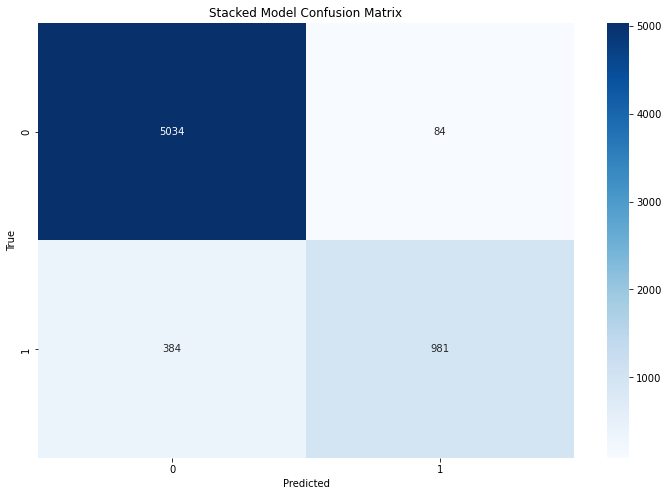

In [44]:
print("F1 Score: {}".format(f1_score(y_test, y_test_pred)))
print("F2 Score: {}".format(stack_model_f2))
print("Accuracy Score: {}".format(stack_model_accuracy))
print_cm(stacked_model_cm, "Stacked Model Confusion Matrix")

AUC: 0.8511343287427696


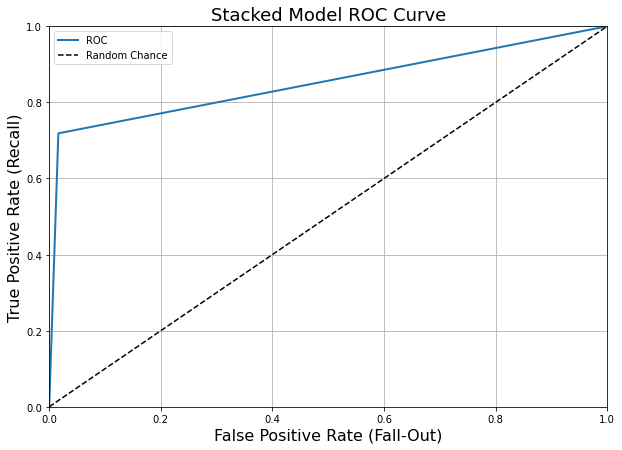

In [51]:
# calculat fpr and tpr
sm_fpr, sm_tpr, _  = roc_curve(y_test, y_test_pred)

plt.figure(figsize=(10, 7))
plot_roc_curve(sm_fpr, sm_tpr, "Stacked Model ROC Curve")
sm_auc = roc_auc_score(y_test, y_test_pred)
print("AUC: {}".format(sm_auc))

By looking at the model performance above, the stacked model approach does perform better than the simple logistic regression, with higher performance metrics all around.

<br>
Let's try a couple other models and see what else performs best.

### Random Forest Model

Next is the Random Forest Model. I'm aware that a Random Forest is just an ensemble of decision trees, and decision trees are not effective on imbalanced data. However, what makes Random Forests different than general bagging, is that not all the features are used, rather a random subset of the features are choosen for every bootstrap sample [3]. This can make each decision tree in the ensemble more independent, which should boost the performance of the overall prediction. I have confidence that this model will perform better than the prior ones.

In [57]:
# Import and Instantiate Random Forest Model
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=99)

# fit model
rf_clf.fit(X_train, y_train)

# make predictions
rf_pred = rf_clf.predict(X_test)

In [58]:
# produce performance metrics

rf_confusion_matrix = confusion_matrix(y_test, rf_pred)
rf_confusion_matrix

rf_f1_score = f1_score(y_test, rf_pred)
rf_f2_score = fbeta_score(y_test, rf_pred, beta=2)

print("F1 Score: {}".format(rf_f1_score))
print("F2 Score: {}".format(rf_f2_score))
rf_confusion_matrix

F1 Score: 0.8290241868223519
F2 Score: 0.7654397042969352


array([[5079,   39],
       [ 371,  994]])

From the metrics above, we can see improved performance across our metrics. We see better F1 and F2 scores. When looking at the confusion matrix, we see a healthy increase in the amount of True Positives, as well as a decrease in both the number of False Positives and False Negatives.

<br>
Next, hyperparameter tuning will be done to see how much better performance we can get from the model.

In [531]:
from sklearn.model_selection import GridSearchCV

param_grid = {"max_depth": [2,6,10,14,18,22,26,30,32],
             "n_estimators":[100,200,300,400,500],
             "min_samples_split":[2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]}

grid_search_rf_clf = GridSearchCV(RandomForestClassifier(random_state=99), param_grid, cv=3)
grid_search_rf_clf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=99),
             param_grid={'max_depth': [2, 6, 10, 14, 18, 22, 26, 30, 32],
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                               12, 13, 14, 15, 16, 17, 18, 19,
                                               20],
                         'n_estimators': [100, 200, 300, 400, 500]})

In [532]:
grid_search_rf_clf.best_params_

{'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 200}

In [534]:
# More Refined grid search

param_grid = {"max_depth": [26, 27, 28 ,29, 30, 31, 32, 33, 34, 35, 36, 37, 38],
             "n_estimators":[150, 160, 170, 180, 185, 190, 195, 200, 205, 210, 215, 220],
             "min_samples_split":[1,2,3,4]}
grid_search_rf_clf = GridSearchCV(RandomForestClassifier(random_state=99), param_grid, cv=3)
grid_search_rf_clf.fit(X_train, y_train)

grid_search_rf_clf.best_params_

{'max_depth': 34, 'min_samples_split': 2, 'n_estimators': 210}

In [541]:
# Final search.
param_grid = {"max_depth": [ 32, 33, 34, 35, 36, 37, 38],
             "n_estimators":[204,205,206,207,208,209, 210,211,212,213,214,215,216],
             "min_samples_split":[1,2,3]}
grid_search_rf_clf = GridSearchCV(RandomForestClassifier(random_state=99), param_grid, cv=3)
grid_search_rf_clf.fit(X_train, y_train)

grid_search_rf_clf.best_params_

{'max_depth': 34, 'min_samples_split': 2, 'n_estimators': 204}

In [59]:
# We have found our best parameters -- let's train a final random forest model

rf_clf_final = RandomForestClassifier(max_depth=34, min_samples_split=2, n_estimators = 204,
                                      random_state=99)
rf_clf_final.fit(X_train, y_train)
rf_pred_final = rf_clf_final.predict(X_test)

In [350]:
%%timeit 
rf_pred_final = rf_clf_final.predict(X_test)

153 ms ± 1.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


F1 Score: 0.830062630480167
F2 Score: 0.765793528505393
Accuracy Score: 0.9372204226438378


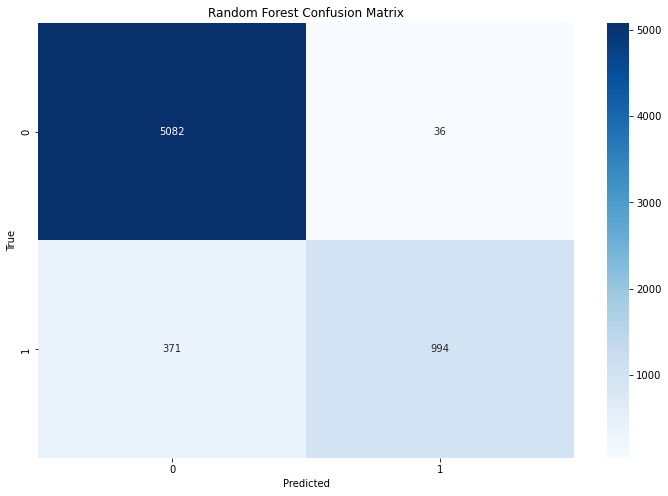

In [212]:
# metrics
rf_confusion_matrix = confusion_matrix(y_test, rf_pred_final)
rf_confusion_matrix

rf_f1_score = f1_score(y_test, rf_pred_final)
rf_f2_score = fbeta_score(y_test, rf_pred_final, beta=2)

print("F1 Score: {}".format(rf_f1_score))
print("F2 Score: {}".format(rf_f2_score))
print("Accuracy Score: {}".format(accuracy_score(y_test, rf_pred_final)))
print_cm(rf_confusion_matrix, "Random Forest Confusion Matrix")

AUC: 0.8605855652748972


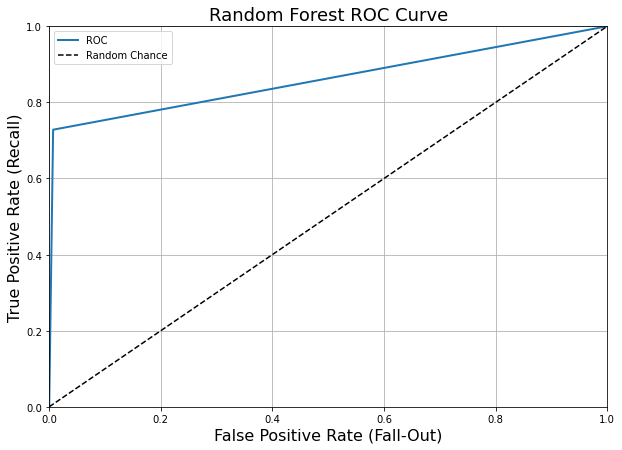

In [210]:
## ROC Curve and AUC

# calculate fpr and tpr
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_pred_final)

# Plot ROC Curve
plt.figure(figsize=(10, 7))
plot_roc_curve(rf_fpr, rf_tpr, "Random Forest ROC Curve")
rf_auc = roc_auc_score(y_test, rf_pred_final)
print("AUC: {}".format(rf_auc))

With an **F1 Score** of **0.830**, an **F2-Score** of **0.766**, and an **AUC** of **0.861**, the Random Forest shows promising ability to predict whether or not a borrower will default on a loan.

In [221]:
# Look at feature importances
view = pd.DataFrame()
view["names"] = X.columns
view["feature_importance"] = rf_clf_final.feature_importances_
view.sort_values(["feature_importance"], ascending=False)

,names,feature_importance
5,loan_percent_income,0.216531
1,person_income,0.145943
4,loan_int_rate,0.111684
3,loan_amnt,0.077342
2,person_emp_length,0.058746
10,person_home_ownership_RENT,0.052092
20,loan_grade_D,0.050941
0,person_age,0.046483
6,cr_history_length,0.034610
7,person_home_ownership_MORTGAGE,0.028964


In comparison to the feature importance table we produced for the logistic regression model, there aren't any clear favorites of models that contributed a significant amount. As expected, features surrounding the interest rate, the loan amount, and the borrower's income came out on top, as well as any features that have some correlation to the three. <br>

One thing that is interesting is that `loan_grade_F` and `loan_grade_G`, features that basically state that a loan is of very poor quality, contributed the least in the Random Forest, whereas they contributed the most in the Logistic Regression.

### XGBoost

The next model that I will build is an XGBoost model. I do have confidence in the gradient boosted trees to perform well on this dataset, but am choosing XGBoost for its popularity of 1) fast execution speed and 2) model performance [4]. 
<br> 

XGBoost is a comparably fast algorithm, if this model that I'm building were to be used by banks, it would be most practical if it were to solve and produce predictions quickly. Also, XGBoost simply dominates in structured/tabular datasets, which is what we are working with.

In [100]:
# Import and instantiate xgboost model
import xgboost as xgb
xgb_clf = xgb.XGBClassifier()

# fit model
xgb_clf.fit(X_train, y_train)

# predict
xgb_preds = xgb_clf.predict(X_test)

[16:29:56] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [349]:
%%timeit 
xgb_preds = xgb_clf.predict(X_test)

3.34 ms ± 163 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


The XGBoost model inferences significantly faster than the Random Forest model (*153 ms ± 1.46 ms per loop)*. This makes a strong candidate to use, especially considering that model speed will be important for use in industry.

F1 Score: 0.842622950819672
F2 Score: 0.7865340474368784
Accuracy Score: 0.940768162887552


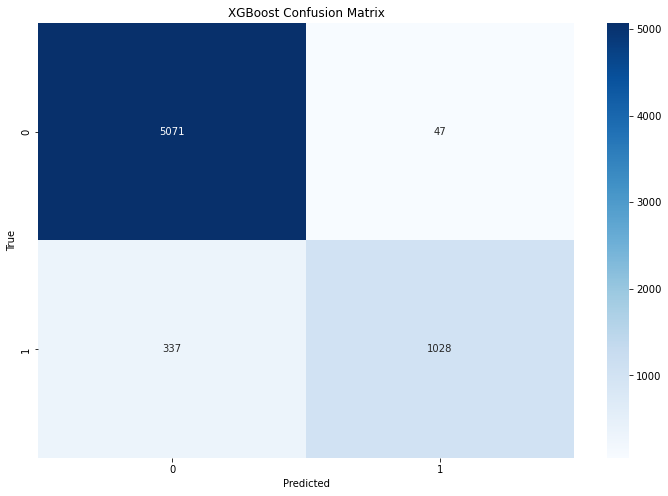

In [124]:
# create confusion matrix
xgboost_cm = confusion_matrix(y_test, xgb_preds)

# Display Metrics
print("F1 Score: {}".format(f1_score(y_test, xgb_preds)))
print("F2 Score: {}".format(fbeta_score(y_test, xgb_preds, beta=2)))
print("Accuracy Score: {}".format(accuracy_score(y_test, xgb_preds)))
print_cm(xgboost_cm, "XGBoost Confusion Matrix")

AUC: 0.8719651391984334


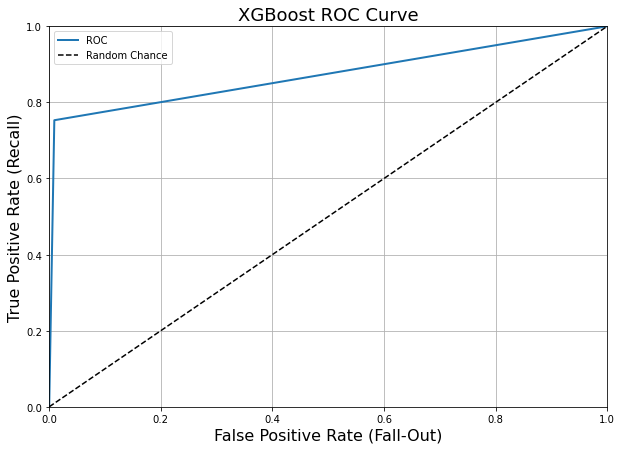

In [213]:
# ROC Curve and AUC

# get fpr and tpr
fpr, tpr, _ = roc_curve(y_test, xgb_preds)

# plot ROC curve
plt.figure(figsize=(10,7))
plot_roc_curve(fpr, tpr, "XGBoost ROC Curve")
xgb_auc = roc_auc_score(y_test, xgb_preds)
print("AUC: {}".format(xgb_auc))

With an **F1 Score** of **0.842**, an **F2-Score** of **0.786**, and an **AUC** of **0.872**, the XGBoost model has shown the best results and seems to be the best model we've built.
<br>

Feature Importance is below.

In [341]:
# feature importance
v3 = pd.DataFrame()
v3["name"] = X.columns
v3["feature_importance"] = xgb_clf.feature_importances_
v3.sort_values(["feature_importance"], ascending=False)

,name,feature_importance
10,person_home_ownership_RENT,0.196804
5,loan_percent_income,0.092497
19,loan_grade_C,0.072389
9,person_home_ownership_OWN,0.066263
11,loan_intent_DEBTCONSOLIDATION,0.063141
20,loan_grade_D,0.054969
13,loan_intent_HOMEIMPROVEMENT,0.048869
17,loan_grade_A,0.048083
8,person_home_ownership_OTHER,0.046938
14,loan_intent_MEDICAL,0.042224


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

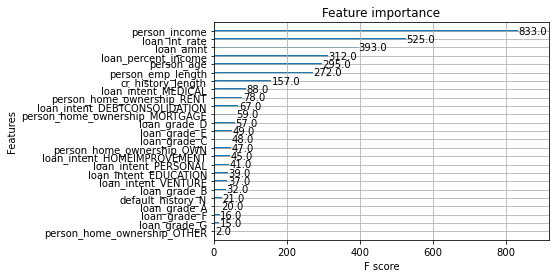

In [346]:
xgb.plot_importance(xgb_clf, importance_type="weight")

Looking at the feature importances above, it's clear to say that there isn't any feature contributing a significant amount, but one thing that surprises me is that `default_history_N` and `default_history_Y` are contributing the least -- I would expect a feature that indicates the default history of a given borrower would be meaningful towards predicting whether loan will default or not.

### LightGBM
Since XGBoost worked very well, I wanted to try a similar gradient boosting tree model, LightGBM. LightGBM differs from XGBoost as if executes significantly faster with very similar performance. It is able to do this for two reasons: 
1. *Gradient-Based One-Side Sampling (GOSS)*
2. *Exclusive Feature Bundling (EFB)* [6].
<br>

Thanks to GOSS, data instances with larger gradients are retained, whereas instances with smaller gradients are randomly sampled. This allows LightGBM to not worry too much about instances that won't help the model learn quicker. On the other hand, EFB allows the model to reduce the number of effective features by bundling sparse features, which reduces dimensionality and increases efficiency [6].

In [325]:
import lightgbm as lgb

# convert the dataset into the proper LGB format
lgb_train = lgb.Dataset(X_train, label = y_train)


# specify parameters
params = {}
params["learning_rate"] = 0.03
params["boosting_type"] = 'gbdt'
params["objective"] = 'binary'
params["metric"] = 'binary_logloss'
params["max_depth"] = 10

# train model
lgbm_clf = lgb.train(params, lgb_train, 100)

#create predictions
lgbm_preds = lgbm_clf.predict(X_test)

    # if lgbm_preds >= 0.5 --> 1, else 0
lgbm_preds = lgbm_preds.round(0)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5724, number of negative: 20204
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000757 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 903
[LightGBM] [Info] Number of data points in the train set: 25928, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220765 -> initscore=-1.261213
[LightGBM] [Info] Start training from score -1.261213


In [326]:
# metrics and confusion matrix
lgbm_cm = confusion_matrix(y_test, lgbm_preds)

#Display Metrics
print("F1 Score: {}".format(f1_score(y_test, xgb_preds)))

F1 Score: 0.823781009409752
F2 Score: 0.7484843774288824
Accuracy Score: 0.9364491747647694


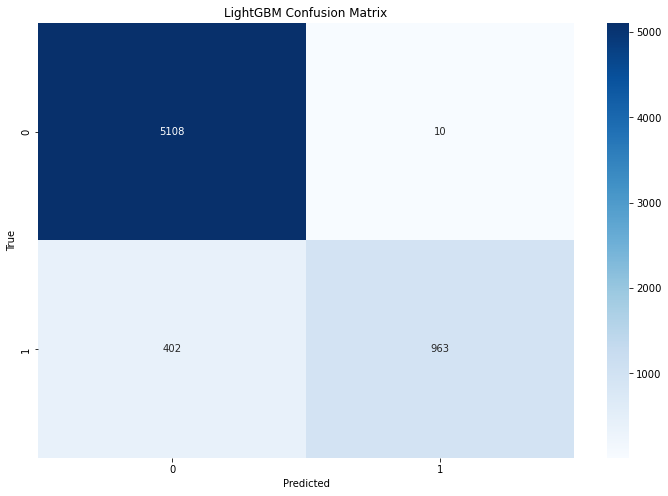

In [327]:
# Display Metrics
print("F1 Score: {}".format(f1_score(y_test, lgbm_preds)))
print("F2 Score: {}".format(fbeta_score(y_test, lgbm_preds, beta=2)))
print("Accuracy Score: {}".format(accuracy_score(y_test, lgbm_preds)))
print_cm(lgbm_cm, "LightGBM Confusion Matrix")

AUC: 0.8517703086284565


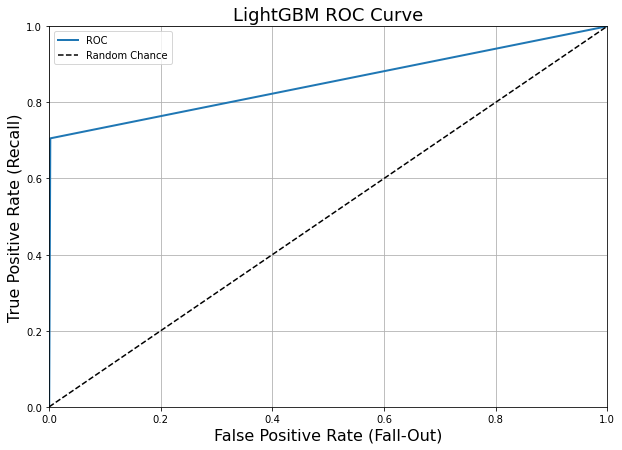

In [328]:
# ROC curve and AUC
lg_fpr, lg_tpr, _ = roc_curve(y_test, lgbm_preds)

plt.figure(figsize=(10,7))
plot_roc_curve(lg_fpr, lg_tpr, "LightGBM ROC Curve")
lgbm_auc = roc_auc_score(y_test, lgbm_preds)
print("AUC: {}".format(lgbm_auc))

Looking at the above metrics, the LightGBM model performed great with an F2 Score of **0.748**. However, it doesn't exceed the metrics achieved by the Random Forest, let alone the XGBoost model.

## Results

We can now compare the performances of all the models we've built. We can reference the below tables where we see the *F1, F2 score, Area under the ROC Curve (AUC), and Accuracy Score* for each model built.

<br>


#### Model Performance

| Model | F1 Score | F2 Score | AUC | Accuracy Score |
| :---        |    :----:   |  :----:   |  :----:   |          ---: |
| Logistic Regression  |    0.644   |   0.594   |  0.757 |  86.9% |
| Stacked Model  |   0.807   |  0.752   |  0.851 |  92.7% |
| Random Forest | 0.830 |   0.766   |  0.861 |  93.7% |
| XGBoost | **0.843** |   **0.787**   |   **0.872**   |   **94.1%** |
| LightGBM | 0.824 |   0.748   |   0.852   |   93.6% |

<br>




In the table above, in bold, we see the metrics of the XGBoost model, which performed the best overall. All things considered, from it's speed, to it's ability to handle unscaled and missing data, and it's effectiveness, the XGBoost model is the best candidate to predict whether or not a borrower will default on their loan.
This will be the model that I will package up and use in my Streamlit app.

##### Saving the Model

In [333]:
import pickle
pickle_out = open("classifier.pkl", mode="wb")
pickle.dump(xgb_clf, pickle_out)
pickle_out.close()

### Resources and Citations

1. Team, T. I. (2022, March 17). What is credit risk? Investopedia. Retrieved April 2, 2022, from https://www.investopedia.com/terms/c/creditrisk.asp 
<br>

2. McCaffrey, O. (2022, February 9). U.S. households took on $1 trillion in new debt in 2021. The Wall Street Journal. Retrieved April 2, 2022, from https://www.wsj.com/articles/u-s-households-took-on-1-trillion-in-new-debt-in-2021-11644342925
<br>

3. Johnson, J. (2021, November 29). What is loan grading? The Balance. Retrieved April 9, 2022, from https://www.thebalance.com/what-is-loan-grading-5211003#:~:text=Loan%20grading%20is%20the%20process,for%20a%20portfolio%20of%20loans 
<br>

4. Brownlee, J. (2021, April 26). Stacking Ensemble Machine Learning with python. Machine Learning Mastery. Retrieved April 9, 2022, from https://machinelearningmastery.com/stacking-ensemble-machine-learning-with-python/ 
<br>

5. Brownlee, J. (2021, January 4). Bagging and random forest for imbalanced classification. Machine Learning Mastery. Retrieved April 9, 2022, from https://machinelearningmastery.com/bagging-and-random-forest-for-imbalanced-classification/ 
<br>

6. Pedersen, T. (2022, March 17). How to use "Model stacking" to improve machine learning predictions. Medium. Retrieved April 9, 2022, from https://medium.com/geekculture/how-to-use-model-stacking-to-improve-machine-learning-predictions-d113278612d4#:~:text=Model%20Stacking%20is%20a%20way,model%20called%20a%20meta%2Dlearner 